# Libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from config import *

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

# Read data

In [40]:
data_dir = '../data'
files = os.listdir(data_dir)

classes = []
for path in files:
    classes.append(path.split('.')[0])
list.sort(classes)


df = {}
for className in classes:
    df[className] = pd.read_csv(os.path.join(data_dir,className+".csv"))

print("Classes: {}".format(classes))
print(df[classes[0]].head(3))

Classes: ['Eye_cover', 'Idle', 'Swing_hand', 'V_hand']
          0         1         2         3         4         5         6  \
0  0.565088  0.486628 -1.454600  0.998598  0.595906  0.421384 -1.366111   
1  0.560797  0.486507 -0.798694  0.998734  0.591997  0.417369 -0.734179   
2  0.555143  0.485822 -0.752496  0.998854  0.586899  0.414073 -0.694277   

          7         8         9  ...       122       123       124       125  \
0  0.997587  0.616399  0.423681  ...  0.190608  0.000433  0.759767  3.451916   
1  0.997820  0.611810  0.417659  ...  1.072129  0.000390  0.759446  3.431489   
2  0.998024  0.606346  0.413350  ...  1.096612  0.000352  0.754640  3.414611   

        126       127       128       129       130       131  
0 -0.169443  0.000873  0.535946  3.427131 -0.632427  0.001365  
1  0.105993  0.000787  0.535968  3.418618  0.347696  0.001230  
2  0.146300  0.000710  0.530272  3.408900  0.389341  0.001108  

[3 rows x 132 columns]


# Create train X, Y

In [41]:
nClass = len(classes)

X = []
y = []

for idx, className in enumerate(classes):
    nSample = len(df[className])
    for start in range(nSample-N_TIME):
        X.append(df[className].iloc[start:start+N_TIME,:])
        one_hot = [0]*nClass
        one_hot[idx] = 1
        y.append(one_hot)

X, y = np.array(X), np.array(y)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (2360, 10, 132)
y shape: (2360, 4)


# Train test split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("[Train]")
print("X shape: {}".format(X_train.shape))
print("y shape: {}".format(y_train.shape))

print("[Test]")
print("X shape: {}".format(X_test.shape))
print("y shape: {}".format(y_test.shape))

[Train]
X shape: (1888, 10, 132)
y shape: (1888, 4)
[Test]
X shape: (472, 10, 132)
y shape: (472, 4)


# Modeling

In [43]:
model = Sequential([
    LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50),
    Dropout(0.2),
    Dense(units = len(classes), activation='softmax')
])

model.compile(
    optimizer = 'adam',
    metrics = ['accuracy'],
    loss = 'categorical_crossentropy'
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 50)            36600     
                                                                 
 dropout_20 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_21 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_21 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_22 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_22 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_23 (LSTM)              (None, 50)               

# Training process

In [44]:
trainingRet = model.fit(
    X_train, 
    y_train,
    epochs = N_EPOCH,
    batch_size = BATCH_SIZE,
    validation_data=(X_test, y_test)
)

model.save('../models/best.h5')

Epoch 1/32
30/30 [==============================] - 6s 59ms/step - loss: 0.9398 - accuracy: 0.7029 - val_loss: 0.4637 - val_accuracy: 0.8602
Epoch 2/32
30/30 [==============================] - 1s 24ms/step - loss: 0.3503 - accuracy: 0.8967 - val_loss: 0.2319 - val_accuracy: 0.9131
Epoch 3/32
30/30 [==============================] - 1s 23ms/step - loss: 0.2378 - accuracy: 0.9333 - val_loss: 0.1730 - val_accuracy: 0.9597
Epoch 4/32
30/30 [==============================] - 1s 22ms/step - loss: 0.2403 - accuracy: 0.9338 - val_loss: 0.1253 - val_accuracy: 0.9682
Epoch 5/32
30/30 [==============================] - 1s 23ms/step - loss: 0.1589 - accuracy: 0.9560 - val_loss: 0.1164 - val_accuracy: 0.9661
Epoch 6/32
30/30 [==============================] - 1s 23ms/step - loss: 0.1579 - accuracy: 0.9560 - val_loss: 0.1243 - val_accuracy: 0.9619
Epoch 7/32
30/30 [==============================] - 1s 22ms/step - loss: 0.1219 - accuracy: 0.9677 - val_loss: 0.0899 - val_accuracy: 0.9746
Epoch 8/32
30

# Plot result

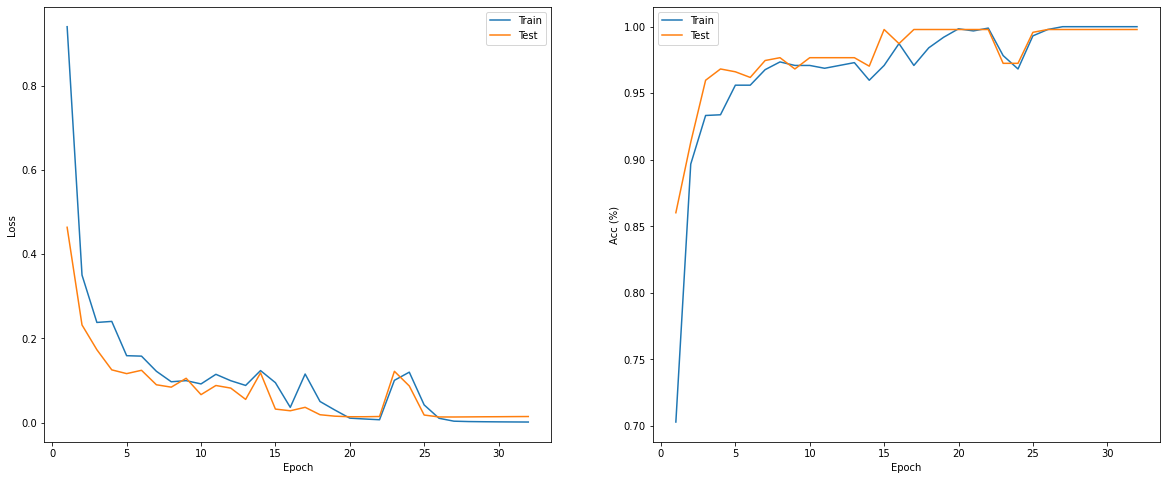

In [45]:
hist = trainingRet.history

fig, ax = plt.subplots(1, 2, figsize=(20,8))
epochs = range(1,N_EPOCH+1)

ax[0].plot(epochs,hist['loss'])
ax[0].plot(epochs,hist['val_loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train','Test'])

ax[1].plot(epochs,hist['accuracy'])
ax[1].plot(epochs,hist['val_accuracy'])
ax[1].set_ylabel('Acc (%)')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train','Test'])

plt.show()